In [4]:
pip install scikit-learn matplotlib gradio


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gradio as gr
import warnings
warnings.filterwarnings("ignore")

In [6]:
# 1. Load Dataset
print("Fetching MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.uint8)

Fetching MNIST dataset...


In [7]:
# 2. Split Data
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000, random_state=42)

# 3. Train Classifiers
print("Training SGDClassifier...")
sgd_clf = SGDClassifier(loss="hinge", random_state=42)
sgd_clf.fit(X_train, y_train)


Training SGDClassifier...


SGDClassifier(random_state=42)

In [8]:
print("Training RandomForestClassifier...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

Training RandomForestClassifier...


RandomForestClassifier(random_state=42)

In [9]:
# 4. Evaluation
def evaluate_model(model, name="Model"):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    return y_pred, acc

print("\nEvaluating classifiers...")
sgd_preds, sgd_acc = evaluate_model(sgd_clf, "SGD Classifier")

# Train RandomForestClassifier if not already trained (assuming this cell will be run after the SGD training)
print("Training RandomForestClassifier...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

rf_preds, rf_acc = evaluate_model(rf_clf, "Random Forest")


Evaluating classifiers...

SGD Classifier Accuracy: 0.8861
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      1022
           1       0.97      0.97      0.97      1142
           2       0.91      0.80      0.85      1011
           3       0.81      0.88      0.84      1037
           4       0.84      0.92      0.88       940
           5       0.91      0.73      0.81       890
           6       0.92      0.96      0.94       929
           7       0.94      0.87      0.91      1042
           8       0.82      0.84      0.83       970
           9       0.84      0.90      0.87      1017

    accuracy                           0.89     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.89      0.89     10000

Training RandomForestClassifier...

Random Forest Accuracy: 0.9692
Classification Report:
               precision    recall  f1-score   support

           


Showing 9 worst misclassifications for Random Forest


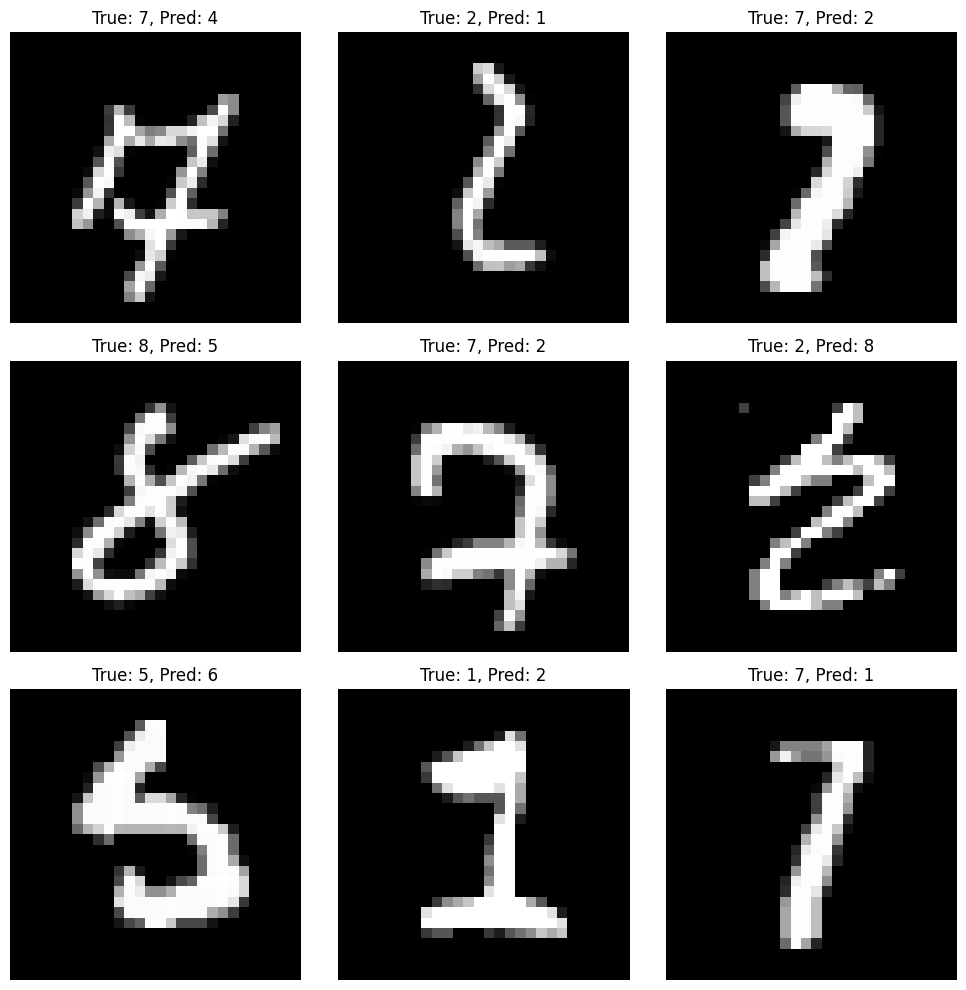

In [10]:
# 5. Visualize Errors
def plot_misclassified(X_test, y_test, y_pred, model_name):
    misclassified = (y_test != y_pred)
    errors = [(x, true, pred) for x, true, pred in zip(X_test[misclassified], y_test[misclassified], y_pred[misclassified])]

    print(f"\nShowing 9 worst misclassifications for {model_name}")
    plt.figure(figsize=(10, 10))
    for i in range(9):
        image, true_label, pred_label = errors[i]
        plt.subplot(3, 3, i+1)
        plt.imshow(image.reshape(28, 28), cmap="gray")
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_misclassified(X_test, y_test, rf_preds, "Random Forest")

In [11]:
def predict_digit(image):
    from skimage.color import rgb2gray
    from skimage.transform import resize

    # Resize to 28x28
    image = resize(image, (28, 28), anti_aliasing=True)

    # Convert to grayscale if needed
    if image.ndim == 3:
        image = rgb2gray(image)

    # Invert color (so digit is black on white like MNIST)
    image = 1.0 - image

    # Flatten and normalize
    image = image.reshape(1, -1)
    image = image / 1.0  # Already scaled to 0–1 range

    prediction = rf_clf.predict(image)[0]
    return str(prediction)


In [12]:
import gradio as gr

interface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Image(),  # No extra arguments
    outputs="label",
    title="MNIST Digit Recognizer (Safe Version)"
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dff5378c3311bc4aa9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


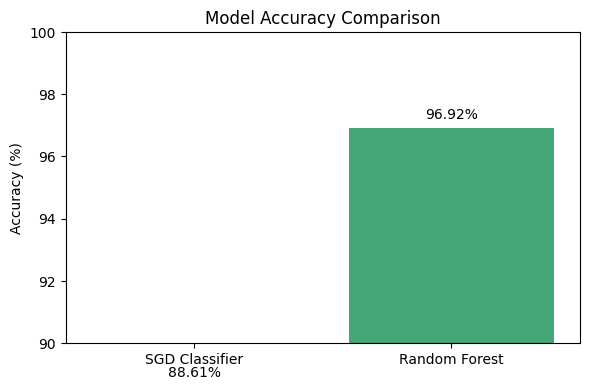

In [13]:
# Calculate accuracy
from sklearn.metrics import accuracy_score

sgd_acc = accuracy_score(y_test, sgd_preds)
rf_acc = accuracy_score(y_test, rf_preds)

# Bar plot comparison
models = ['SGD Classifier', 'Random Forest']
accuracies = [sgd_acc * 100, rf_acc * 100]

plt.figure(figsize=(6, 4))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(90, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.2, f"{acc:.2f}%", ha='center', va='bottom')
plt.tight_layout()
plt.show()


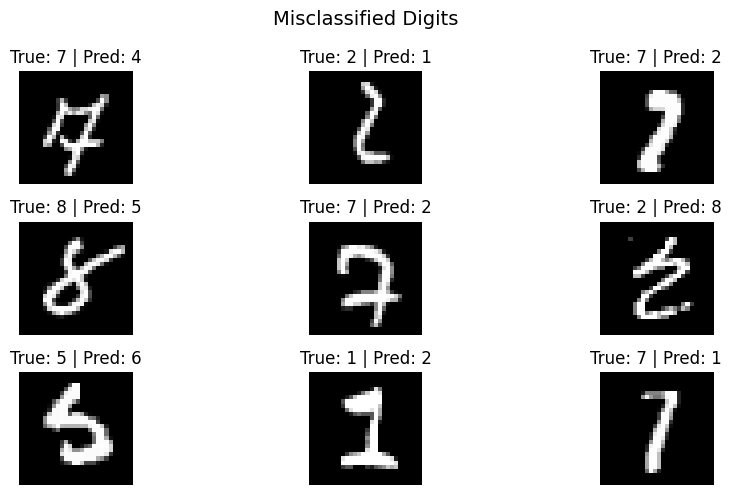

In [14]:
def plot_misclassified(X_test, y_true, y_pred, total=9):
    misclassified_indices = np.where(y_true != y_pred)[0]
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(misclassified_indices[:total]):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_true[idx]} | Pred: {y_pred[idx]}")
        plt.axis('off')
    plt.suptitle("Misclassified Digits", fontsize=14)
    plt.tight_layout()
    plt.show()

# Use with Random Forest predictions
plot_misclassified(X_test, y_test, rf_preds)


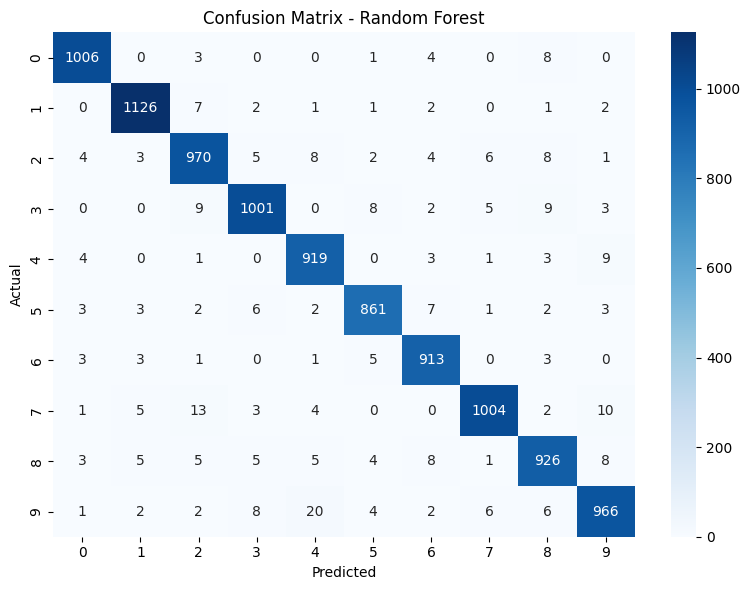

In [15]:
# 📉 Confusion Matrix (Random Forest)
cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


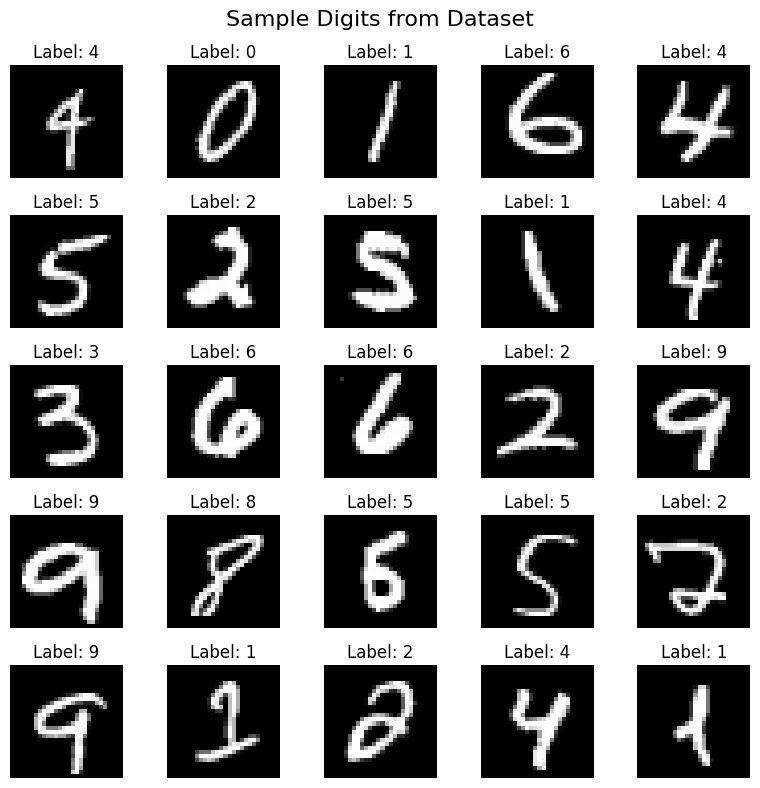

In [16]:
def show_sample_digits(images, labels, total=25):
    plt.figure(figsize=(8, 8))
    for i in range(total):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle("Sample Digits from Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_digits(X_train, y_train)


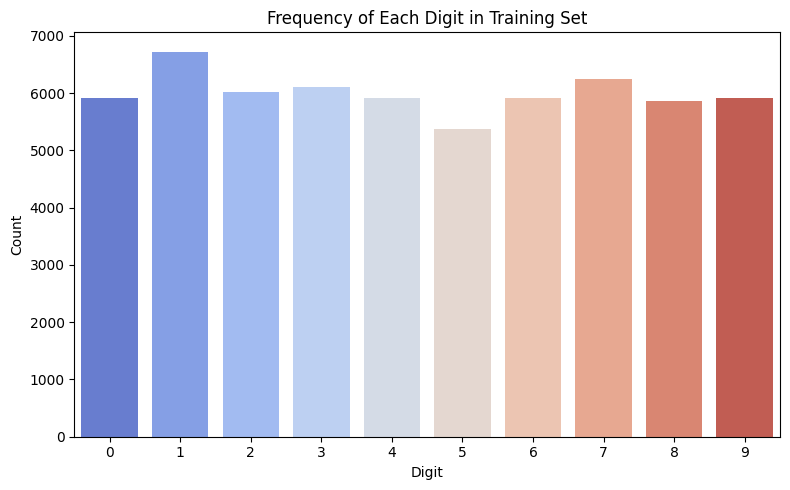

In [19]:
import pandas as pd

digit_counts = pd.Series(y_train).value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=digit_counts.index, y=digit_counts.values, palette='coolwarm')
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("Frequency of Each Digit in Training Set")
plt.tight_layout()
plt.show()


Fetching MNIST dataset...
Training RandomForestClassifier...


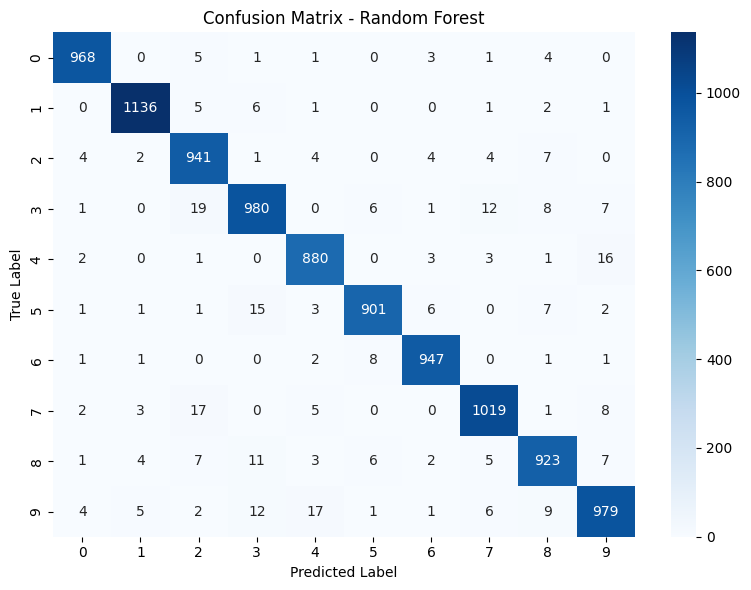

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Load Dataset
print("Fetching MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(np.uint8)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000, random_state=42)

# Train RandomForestClassifier
print("Training RandomForestClassifier...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Make predictions
rf_preds = rf_clf.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, rf_preds)

# Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

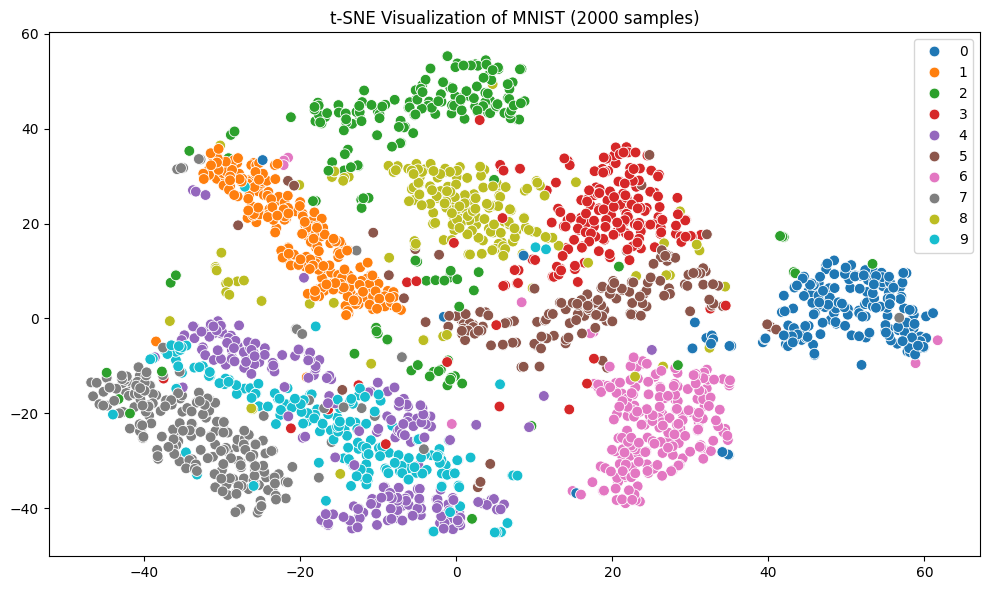

In [20]:
from sklearn.manifold import TSNE

# Reduce dataset for speed
X_subset = X_train[:2000]
y_subset = y_train[:2000]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_subset)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_subset, palette='tab10', legend='full', s=60)
plt.title("t-SNE Visualization of MNIST (2000 samples)")
plt.tight_layout()
plt.show()


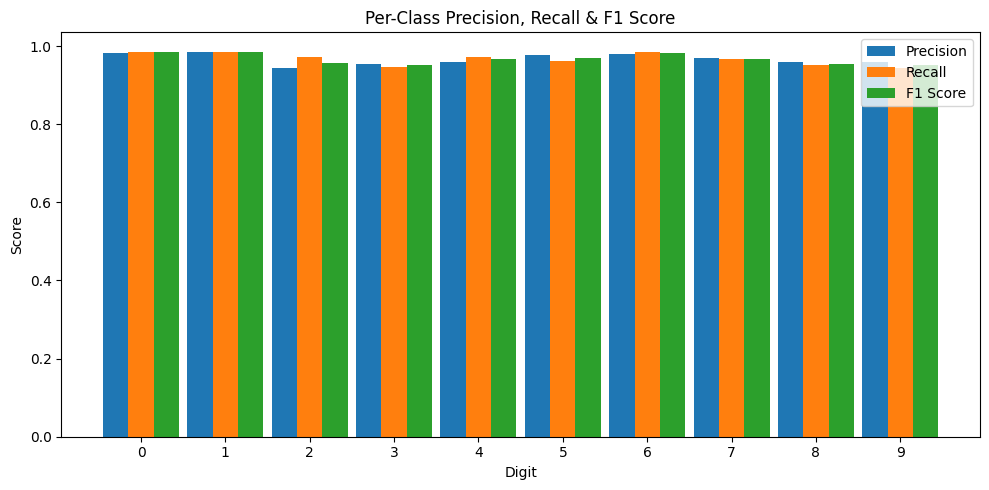

In [21]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, rf_preds, average=None)

plt.figure(figsize=(10, 5))
labels = np.arange(10)

x = np.arange(len(labels))
width = 0.3

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xlabel("Digit")
plt.ylabel("Score")
plt.title("Per-Class Precision, Recall & F1 Score")
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()
